In [8]:
import math
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import numba
from numba import njit
import time
from matplotlib.pyplot import figure
# !pip install ortools
# import ortools

# from ortools.constraint_solver import routing_enums_pb2

# from ortools.constraint_solver import pywrapcp
from numba.typed import List
from collections import defaultdict


In [9]:
n = 200
item= []
for i in range(n//4):
    a= rd.randint(20,30)
    b= rd.randint(20,30)
    item.append(np.array([a,b], np.int_))
for i in range(n//4):
    a= rd.randint(50,80)
    b= rd.randint(10,20)
    item.append(np.array([a,b], np.int_))
for i in range(n//4):
    a= rd.randint(20,30)
    b= rd.randint(80,90)
    item.append(np.array([a,b], np.int_))
for i in range(n//4):
    a= rd.randint(70,90)
    b= rd.randint(80,90)
    item.append(np.array([a,b], np.int_))
item= np.array( item, np.int_)
capacity = 500
time = 2000
min_time = min([item_i[0] for item_i in item])
min_capacity = min([item_i[1] for item_i in item])

In [10]:
@njit
def guillotine(s, item):
    list_bin = np.empty((1, 3), np.int_)
    list_bin[0] = np.array([time,capacity,0], np.int_)
    best_space = 0
    best_time = 0
    for i in range(len(s)):
      for j in range(len(list_bin)):
          if item[s[i], 0] <= list_bin[j][0] and item[s[i], 1] <= list_bin[j][1]:
              bin_left = np.array([item[s[i], 0], list_bin[j][1] - item[s[i], 1], list_bin[j][2]], np.int_)
              bin_right = np.array([list_bin[j][0] - item[s[i], 0], list_bin[j][1], list_bin[j][2] + item[s[i], 0]], np.int_)
              best_time = max(best_time, list_bin[j][2] +item[s[i], 0])
              if bin_right[0] >= min_time and bin_left[1] >= min_capacity:
                  new_list_bin = np.empty((len(list_bin) + 1, 3), np.int_)
                  new_list_bin[:j] = list_bin[:j]
                  new_list_bin[j] = bin_left
                  new_list_bin[j+1] = bin_right
                  new_list_bin[j+2:] = list_bin[j+1:]
                  list_bin = new_list_bin
              elif bin_right[0] >= min_time: list_bin[j] = bin_right
              elif bin_left[1] >= min_capacity: list_bin[j] = bin_left
              else:
                  new_list_bin = np.empty((len(list_bin) - 1, 3), np.int_)
                  new_list_bin[:j] = list_bin[:j]
                  new_list_bin[j:] = list_bin[j+1:]
                  list_bin = new_list_bin
              best_space += item[s[i],0] * item[s[i],1]
              break
    return best_space, best_time

In [11]:
@njit
def ls(s,k, item):
    best_space, best_time = guillotine(s,item)
    print(best_space, best_time)
    for _ in range(k):
        new_item = np.copy(item)
        j = len(s)%k
        for i in range(j-len(s), j):
            new_item[s[i]][0], new_item[s[i]][1] = new_item[s[i]][1], new_item[s[i]][0]
            a,b=  guillotine(s,new_item)
            if a > best_space or a == best_space and b < best_time:
                item = new_item.copy()
                best_space=a
                best_time=b
                print(best_space, best_time)
    for _ in range(k):
        new_item = np.copy(item)
        i= rd.randint(0,len(s)-2)
        j= rd.randint(i+1,len(s)-1)
        new_item[s[i]], new_item[s[j]] = new_item[s[j]].copy(),new_item[s[i]].copy()
        a,b= guillotine(s, new_item)
        if a > best_space or a == best_space and b < best_time:
            item = new_item.copy()
            best_space=a
            best_time=b
            print(best_space, best_time)
    return item

In [12]:
A = list(range(len(item)))
A.sort(key= lambda x:-item[x][0])
s = np.array(A, np.int_)
item = ls(s,1000,item)
guillotine(s,item)

527504 1107
527504 1106


(527504, 1106)

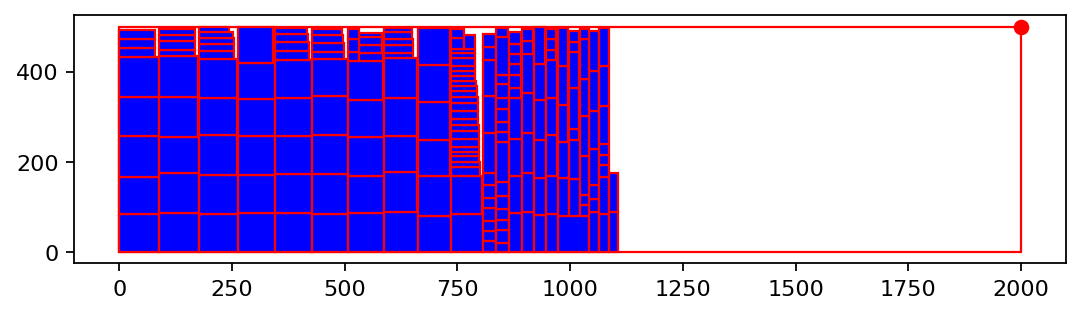

In [13]:
from matplotlib.patches import Rectangle
def rec(x,y,l,w,color):
    rec= Rectangle((x,y),l,w,linewidth=1,edgecolor='r',facecolor=color)
    plt.gca().add_patch(rec)
from matplotlib.pyplot import figure
def guillotine_draw(s):

    figure(figsize=(8, 16), dpi=160)
    plt.gca().set_aspect('equal')

    plt.plot(time, capacity, "ro")
    rec(x=0,y=0,l=time,w=capacity,color='none')
    pv_x = 0
    pv_y = 0
    list_bin = np.empty((1, 4), np.int_)
    list_bin[0] = np.array([time,capacity,0,0], np.int_)
    for i in range(len(s)):
        for j in range(len(list_bin)):
            if item[s[i], 0] <= list_bin[j][0] and item[s[i], 1] <= list_bin[j][1]:
                pv_x = list_bin[j][2]
                pv_y = list_bin[j][3]
                rec(x=pv_x, y=pv_y,l=item[s[i],0],w=item[s[i],1], color="blue")
                bin_left = np.array([item[s[i], 0], list_bin[j][1] - item[s[i], 1], pv_x, pv_y + item[s[i], 1]], np.int_)
                bin_right = np.array([list_bin[j][0] - item[s[i], 0], list_bin[j][1], pv_x + item[s[i], 0], pv_y], np.int_)
                if bin_right[0] >= min_time and bin_left[1] >= min_capacity:
                    new_list_bin = np.empty((len(list_bin) + 1, 4), np.int_)
                    new_list_bin[:j] = list_bin[:j]
                    new_list_bin[j] = bin_left
                    new_list_bin[j+1] = bin_right
                    new_list_bin[j+2:] = list_bin[j+1:]
                    list_bin = new_list_bin
                elif bin_right[0] >= min_time: list_bin[j] = bin_right
                elif bin_left[1] >= min_capacity: list_bin[j] = bin_left
                else:
                    new_list_bin = np.empty((len(list_bin) - 1, 4), np.int_)
                    new_list_bin[:j] = list_bin[:j]
                    new_list_bin[j:] = list_bin[j+1:]
                    list_bin = new_list_bin
                break
guillotine_draw(s)